## IPEX Examples (https://intel.github.io/intel-extension-for-pytorch/latest/index.html)


### IPEX Structure

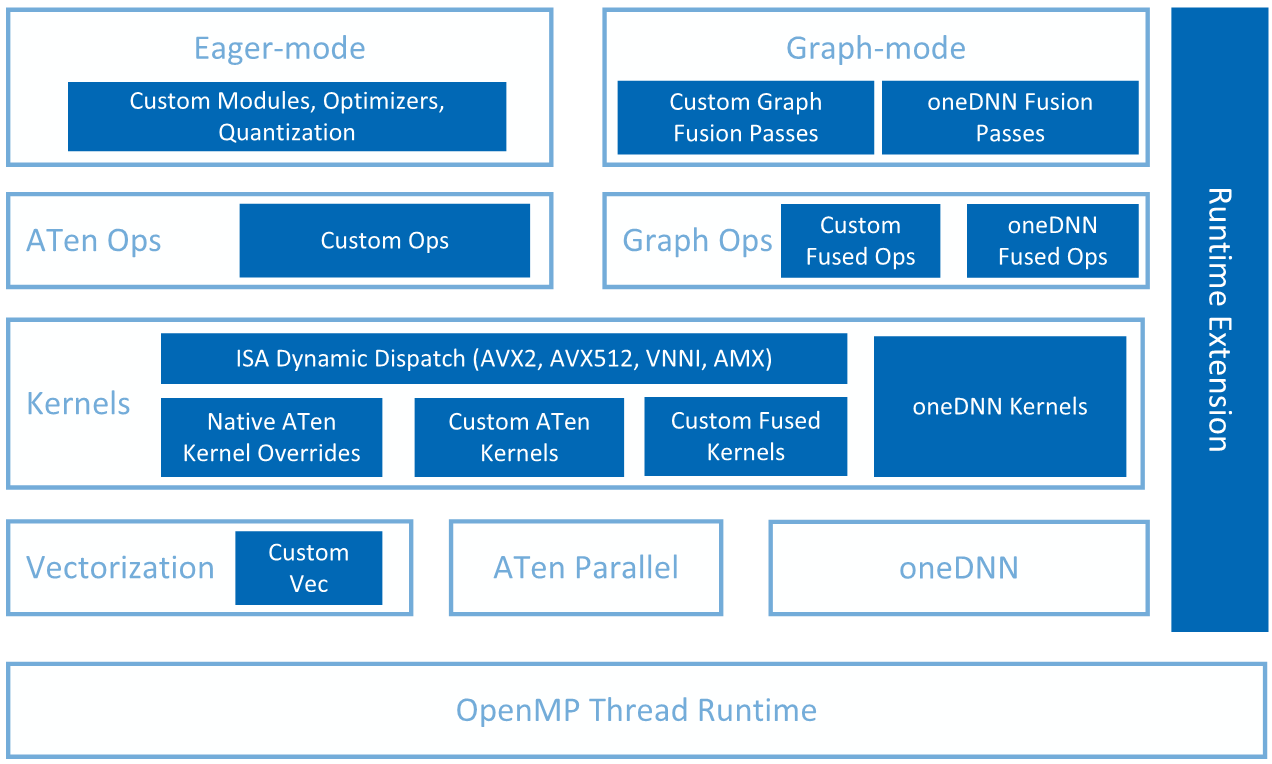

# Training using IPEX

In [28]:
import torch
import torchvision

LR = 0.001
DOWNLOAD = True
DATA = 'datasets/cifar10/'


In [29]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = torchvision.datasets.CIFAR10(
        root=DATA,
        train=True,
        transform=transform,
        download=DOWNLOAD,
)
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=128
)

Files already downloaded and verified


### Channels Last

Channels last is a memory layout format that is more friendly to Intel Architecture. We recommend using this memory layout format for computer vision workloads by invoking to(memory_format=torch.channels_last) function against the model object and input data.

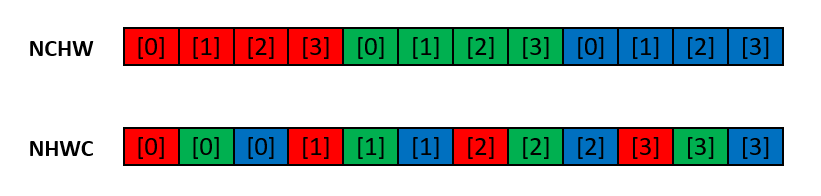

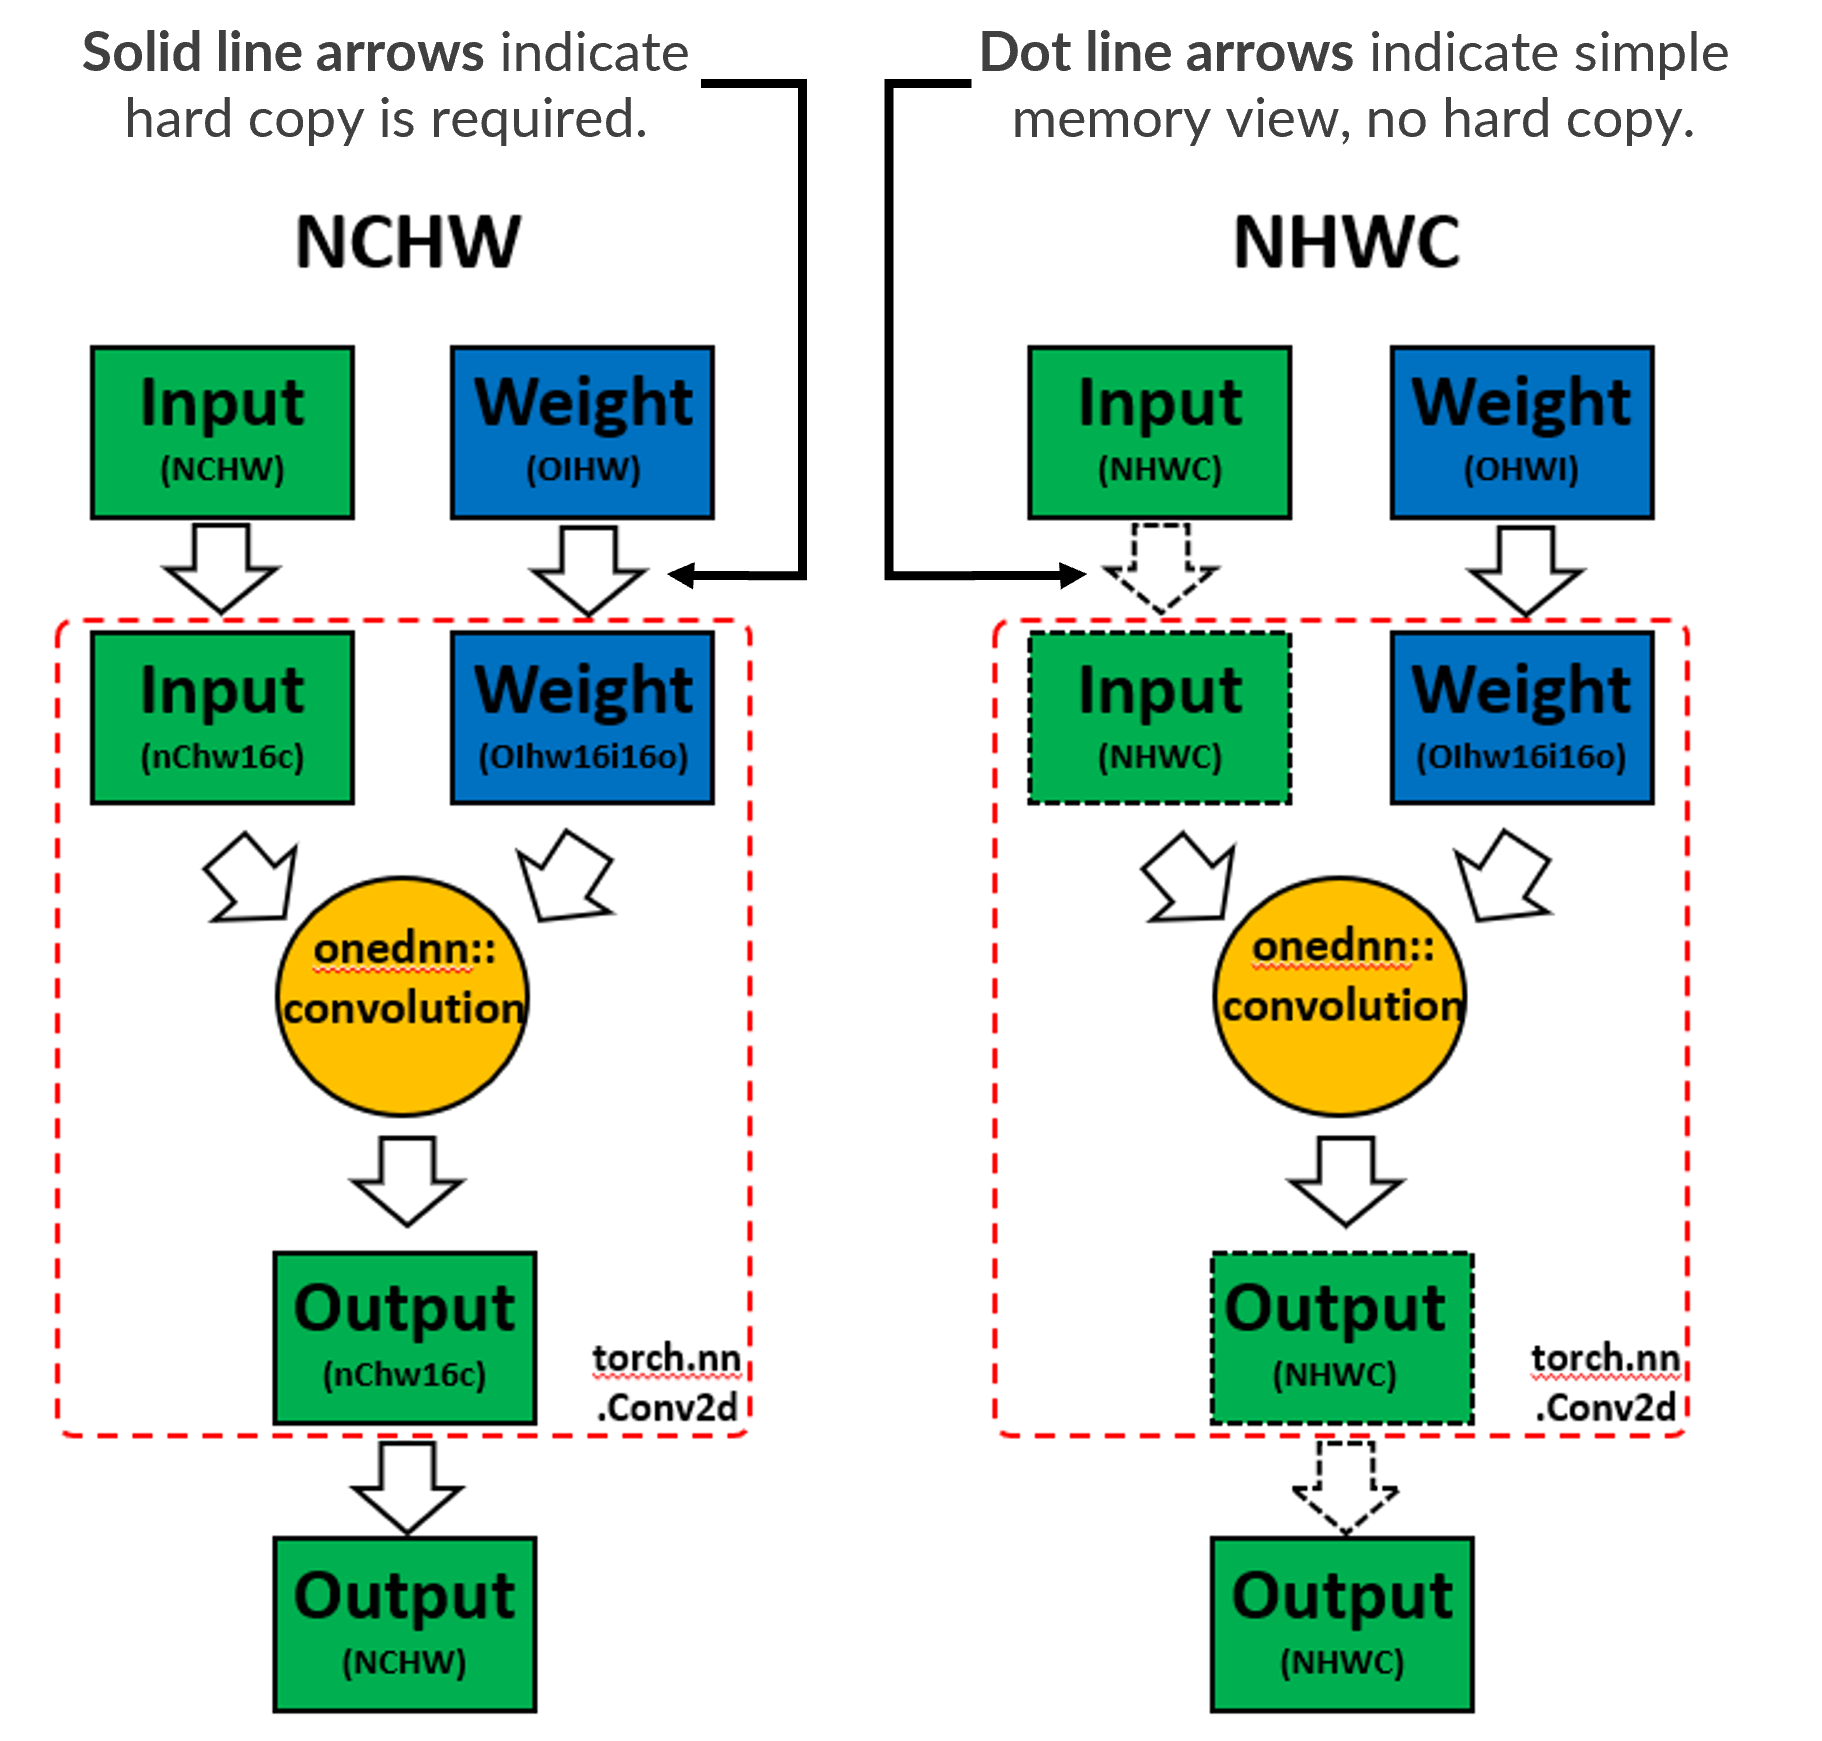

In [30]:
model = torchvision.models.resnet50()
model = model.to(memory_format=torch.channels_last)

In [31]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LR, momentum=0.9)
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### IPEX integration

The optimize function of Intel® Extension for PyTorch* applies optimizations to the model, bringing additional performance boosts. For both computer vision workloads and NLP workloads, we recommend applying the optimize function against the model object.


In [32]:
#################### code changes ####################
import intel_extension_for_pytorch as ipex
model, optimizer = ipex.optimize(model, optimizer=optimizer)
######################################################

### Training loop

In [33]:
for batch_idx, (data, target) in enumerate(train_loader):
    # Setting memory_format to torch.channels_last could improve performance with 4D input data. This is optional.
    data = data.to(memory_format=torch.channels_last)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    print(batch_idx)
    break
torch.save({
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict(),
     }, 'checkpoint.pth')

print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')

0
[CODE_SAMPLE_COMPLETED_SUCCESFULLY]


# Inference using IPEX: Imperative mode

In [34]:
import torch
import torchvision.models as models

In [35]:
model = models.resnet50(pretrained=True)
model.eval()
data = torch.rand(1, 3, 224, 224)

In [36]:
model = model.to(memory_format=torch.channels_last)
data = data.to(memory_format=torch.channels_last)

### IPEX integration

In [37]:
#################### code changes ####################
import intel_extension_for_pytorch as ipex
model = ipex.optimize(model)
######################################################

### Output

In [38]:
with torch.no_grad():
  model(data)

print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')

[CODE_SAMPLE_COMPLETED_SUCCESFULLY]


# Inference using IPEX: Imperative mode with BFloat16 

In [39]:
import torch
import torchvision.models as models

In [40]:
model = models.resnet50(pretrained=True)
model.eval()
data = torch.rand(1, 3, 224, 224)

In [41]:
model = model.to(memory_format=torch.channels_last)
data = data.to(memory_format=torch.channels_last)

### IPEX integration with bfloat16

Similar to running with FP32, the optimize function also works for BFloat16 data type. The only difference is setting dtype parameter to torch.bfloat16. We recommend using Auto Mixed Precision (AMP) with BFloat16 data type.

In [42]:
#################### code changes ####################
import intel_extension_for_pytorch as ipex
model = ipex.optimize(model, dtype=torch.bfloat16)
######################################################

### Output with Auto Mixed Precision (AMP)

torch.cpu.amp provides convenience for auto data type conversion at runtime. Deep learning workloads can benefit from lower-precision floating point data types such as torch.float16 or torch.bfloat16, because of its lighter calculation workload and smaller memory usage. Accuracy is sacrificed when using lower-precision floating point data types so there’s a trade-off between accuracy and performance. Thus, some operations should use the slower but more accuratetorch.float32, while others can be converted to use the faster but less accurate torch.float16 data type. The Auto Mixed Precision (AMP) feature automates the tuning of data type conversions over all operators.

torch.cpu.amp only supports torch.bfloat16. It is the default lower precision floating point data type when torch.cpu.amp is enabled. torch.cpu.amp primarily benefits when running on Intel CPU with BFloat16 instruction set support.

In [43]:
with torch.no_grad():
  with torch.cpu.amp.autocast():
    model(data)
    
print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')

[CODE_SAMPLE_COMPLETED_SUCCESFULLY]


# Inference using IPEX: TorchScript Mode

We recommend you take advantage of Intel® Extension for PyTorch* with TorchScript for further optimizations.

Most Deep Learning models could be described as a DAG (directed acyclic graph). Optimizing a deep learning model from a graph perspective is straight forward. Compared to the operator optimization and algorithm optimization, the graph optimization is at a higher level. It covers not only the graph but also the runtime. From the operator perspective, the graph optimization contains the operator fusing and constant folding. From the runtime perspective, the graph optimization contains the operator scheduling, computation resources management, and memory management.

The Intel® Extension for PyTorch* focuses on operator related graph optimizations. The extension also provides some experimental features for the related runtime optimizations.



In [44]:
import torch
import torchvision.models as models

In [45]:
model = models.resnet50(pretrained=True)
model.eval()
data = torch.rand(1, 3, 224, 224)

In [46]:
model = model.to(memory_format=torch.channels_last)
data = data.to(memory_format=torch.channels_last)

### IPEX integration

In [47]:
#################### code changes ####################
import intel_extension_for_pytorch as ipex
model = ipex.optimize(model)
######################################################

### Output with TorchScript mode

In [48]:
with torch.no_grad():
  d = torch.rand(1, 3, 224, 224)
  model = torch.jit.trace(model, d)
  model = torch.jit.freeze(model)

  model(data)
    
print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')

[CODE_SAMPLE_COMPLETED_SUCCESFULLY]


### Some Results

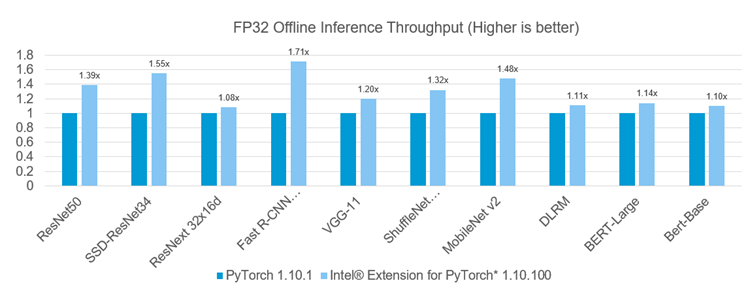
###### credits: https://medium.com/pytorch/accelerating-pytorch-with-intel-extension-for-pytorch-3aef51ea3722 